<a href="https://colab.research.google.com/github/DuyDucNguyen/Practical_FEM_FEniCS_Colab/blob/master/wave_equation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Wave Equation

In [0]:
# This program shows how to implement Wave Equation

# Reference: This program is followed an example of the course 'edx.org - KTHx - High Performance Finite Element Modeling'. 
# The author modifies it up to date and give clear explaination.  

# Copyright (C) 2019 Duy Duc NGUYEN (duyduc.nguyen@protonmail.com)

# This file is part of DOLFIN.

# DOLFIN is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# DOLFIN is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the
# GNU Lesser General Public License for more details.

# You should have received a copy of the GNU Lesser General Public License
# along with DOLFIN. If not, see <http://www.gnu.org/licenses/>.

# First added:  2019-09-23
# Last changed: 2019-09-23

# This demo is maintained by Duy Duc NGUYEN
# Please report possible problems to duyduc.nguyen@protonmail.com

In [0]:
# install Fenics: 2 mins
from google.colab import files

import platform, sys
python_version=platform.python_version()
from distutils.version import LooseVersion, StrictVersion

if ( LooseVersion(python_version) < LooseVersion("3.0.0")):
    print("Python3 is needed!");
    print("How to fix: Runtime/Change_runtime_type/Python 3");
    sys.exit()
    
try:
    from dolfin import *; from mshr import *
except ImportError as e:
    !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
    !add-apt-repository -y ppa:fenics-packages/fenics
    !apt-get update -qq
    !apt install -y --no-install-recommends fenics
    from dolfin import *; from mshr import *
    
import matplotlib.pyplot as plt;
from IPython.display import clear_output, display; import time; import dolfin.common.plotting as fenicsplot 
import time

import os, sys, shutil

dolfin_version = dolfin.__version__
print ('dolfin version:', dolfin_version)

!rm -rf * # clean up all files
# Useful commands
# Remove an empty folder      : os.rmdir("my_results")
# Remove a folder with files  : shutil.rmtree("results")
# Make a folder               : os.mkdir("my_results")
# Runtime/Change_runtime_type/Python3


Consider the wave equation

\begin{equation}
\left\{ \begin{array}{ccc}
\dfrac{\partial^{2}u}{\partial t^{2}}=c^{2}\Delta u+f & \text{ in } & \Omega\end{array}\right.
\end{equation}

Let $v=\partial_{t}u$, it becomes
\begin{equation}
\left\{ \begin{array}{ccc}
\dfrac{\partial v}{\partial t}=c^{2}\Delta u+f & \text{ in } & \Omega\\
\dfrac{\partial u}{\partial t}=v & \text{ in } & \Omega
\end{array}\right.
\end{equation}

Functions $u,v$, test function $\overline{u},\overline{v}$. The
weak form
\begin{align*}
F_{v} & =\int_{\Omega}\dfrac{\partial v}{\partial t}\overline{v}\ \mathrm{d}x+c^{2}\int_{\Omega}\nabla u\cdot\nabla\overline{v}\ \mathrm{d}x-\int_{\Omega}f\overline{v}\ \mathrm{d}x=0\\
F_{u} & =\int_{\Omega}\dfrac{\partial u}{\partial t}\overline{u}\ \mathrm{d}x-\int_{\Omega}v\overline{u}\ \mathrm{d}x\\
F & =F_{v}+F_{u}
\end{align*}


/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


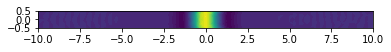

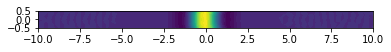

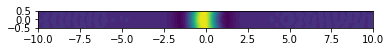

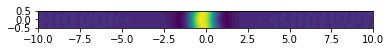

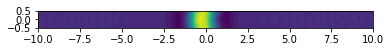

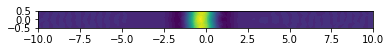

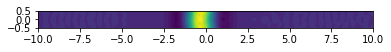

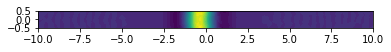

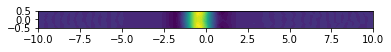

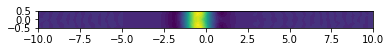

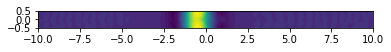

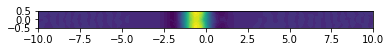

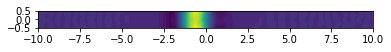

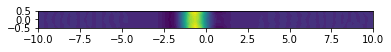

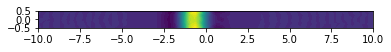

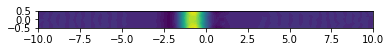

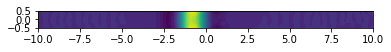

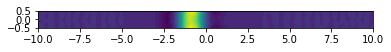

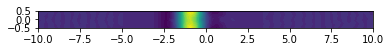

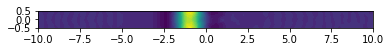

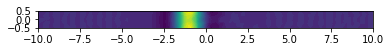

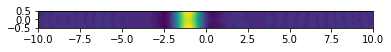

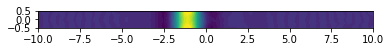

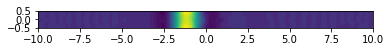

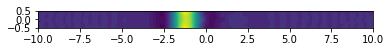

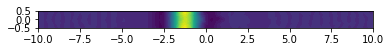

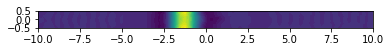

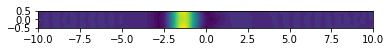

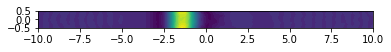

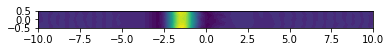

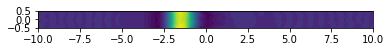

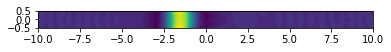

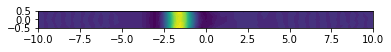

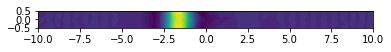

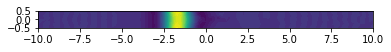

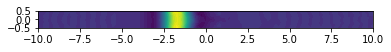

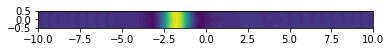

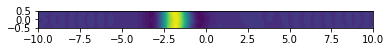

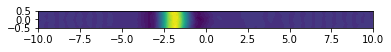

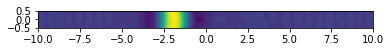

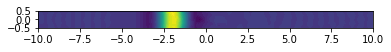

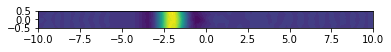

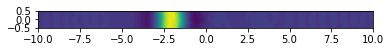

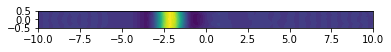

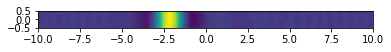

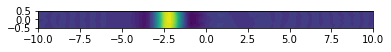

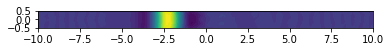

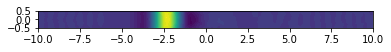

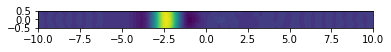

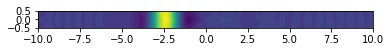

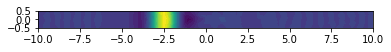

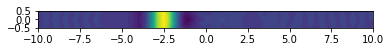

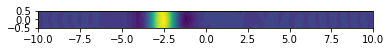

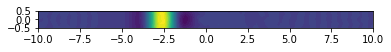

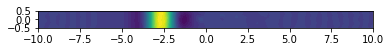

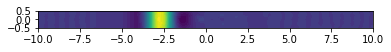

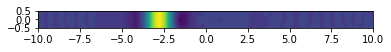

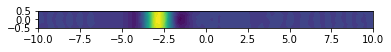

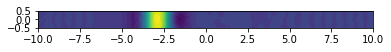

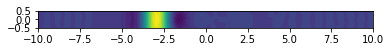

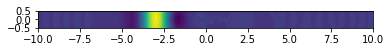

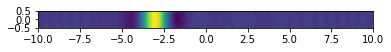

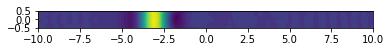

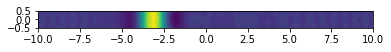

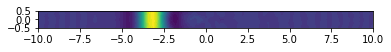

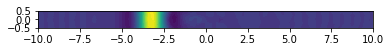

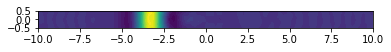

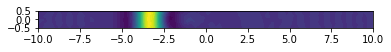

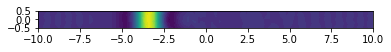

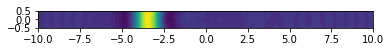

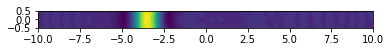

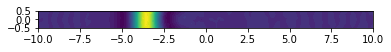

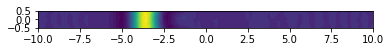

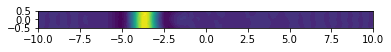

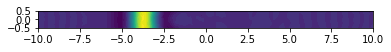

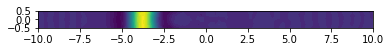

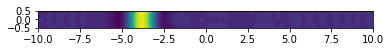

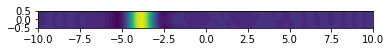

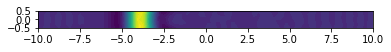

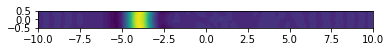

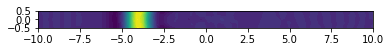

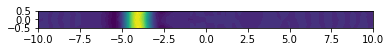

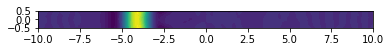

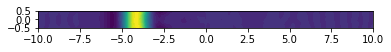

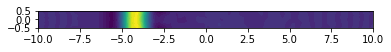

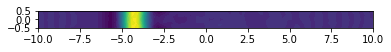

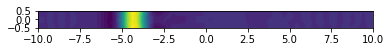

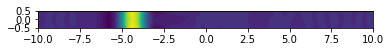

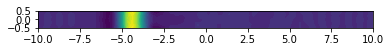

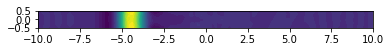

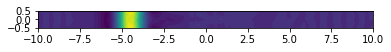

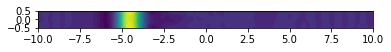

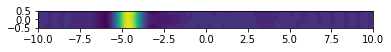

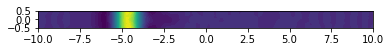

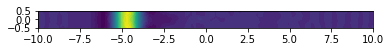

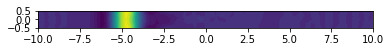

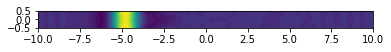

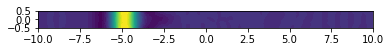

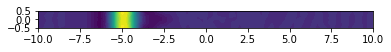

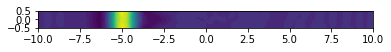

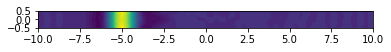

Relative L2_error= 0.08174857139106013


In [8]:
from mshr import *; 
from IPython.display import display, clear_output; import time
import logging; 
logging.getLogger('FFC').setLevel(logging.WARNING)

import numpy as np
import matplotlib.pyplot as plt

set_log_active(False)

# Plot Function
import matplotlib.tri as tri


def mesh2triang(mesh):
	xy = mesh.coordinates()
	return tri.Triangulation(xy[:, 0], xy[:, 1], mesh.cells())


def mplot_function(f):
	mesh = f.function_space().mesh()
	if (mesh.geometry().dim() != 2):
		raise AttributeError('Mesh must be 2D')

	# DG0 cellwise function
	if f.vector().size() == mesh.num_cells():
		C = f.vector().array()
		return plt.tripcolor(mesh2triang(mesh), C)

	# Scalar function, interpolated to vertices
	elif f.value_rank() == 0:
		C = f.compute_vertex_values(mesh)
		return plt.tripcolor(mesh2triang(mesh), C, shading='gouraud')

	# Vector function, interpolated to vertices
	elif f.value_rank() == 1:
		w0 = f.compute_vertex_values(mesh)
		if (len(w0) != 2*mesh.num_vertices()):
			raise AttributeError('Vector field must be 2D')

	X = mesh.coordinates()[:, 0]
	Y = mesh.coordinates()[:, 1]
	U = w0[:mesh.num_vertices()]
	V = w0[mesh.num_vertices():]
	return plt.quiver(X,Y,U,V)


# Compact plot utility function
def plot_compact(u, t, stepcounter): 
	if stepcounter % 5 == 0:
		uEuclidnorm = project(u, Q); 
		ax.cla(); 
		fig = plt.gcf();
		fig.set_size_inches(16, 2)

		# Plot norm of velocity
		plt.subplot(1, 2, 1); 
		mplot_function(uEuclidnorm); 
		plt.title("Wave")
		if t == 0.: 
			plt.colorbar(); 
			plt.axis(G)
		plt.colorbar(); 
		plt.axis(G)

		# Plot mesh
		plt.subplot(1, 2, 2);
		plt.triplot(mesh2triang(mesh)); 
		plt.title("Mesh")
		if t == 0.: 
			plt.triplot(mesh2triang(mesh)); 
			plt.title("Mesh")
		display(pl)

		plt.suptitle("Wave - t: %f" % (t)); 
		plt.tight_layout(); 
		clear_output(wait=True);

		plt.show()


# Define domain and mesh
XMIN, XMAX = -10., 10.;
YMIN, YMAX = -0.5, 0.5;
G = [XMIN, XMAX, YMIN, YMAX];
mresolution = 50;
mesh = generate_mesh(Rectangle(Point(G[0], G[2]), Point(G[1], G[3])), mresolution)

# Define function spaces and functions
Q = FunctionSpace(mesh, "CG", 1); 

fi_ele   = FiniteElement("CG", mesh.ufl_cell(), 1)
elements = MixedElement([fi_ele, fi_ele])
W = FunctionSpace(mesh, elements)

h = mesh.hmin();

wt = TestFunction(W);
(ut, vt) = split(wt)

w = Function(W); 
(u, v) = split(w);

# initial functions
w0 = Function(W); 
(u0, v0) = split(w0); 

# Time interval and time step
t, T = 0., 5.;
dt = 0.05;
c = 1;

# Define the Dirichlet boundary  
def boundary(x, on_boundary):
	return on_boundary

# Initial solution
option = 1;
if option==0:
	ue = Expression("(1-pow(a*t-x[0],2))*exp(-pow(a*t-x[0],2)) + (1-pow(a*t+x[0],2))*exp(-pow(a*t+x[0],2))", a=c, t=0, domain=mesh, degree=2);
	ve = Expression("2*a*(a*t-x[0])*(pow(a*t-x[0],2)-2)*exp(-pow(a*t-x[0],2)) + 2*a*(a*t+x[0])*(pow(a*t+x[0],2)-2)*exp(-pow(a*t+x[0],2))", a=c, t=0, domain=mesh, degree=2)

if option==1:
	ue = Expression("(1-pow(a*t+x[0],2))*exp(-pow(a*t+x[0],2))", a=c, t=0, domain=mesh, degree=2);
	ve = Expression("2*a*(a*t+x[0])*(pow(a*t+x[0],2)-2)*exp(-pow(a*t+x[0],2))", a=c, t=0, domain=mesh, degree=2)


# Boundary conditions
bcu = DirichletBC(W.sub(0), ue, boundary)
bcv = DirichletBC(W.sub(1), ve, boundary)
bcs = [bcu, bcv];

# Initial solution
u0 = ue;
v0 = ve;

# Time scheme parameter
theta = 0.5;

# Time-stepping loop 
while t < T:
	# Weak form of wave equation
	vm = theta*v + (1.0-theta)*v0;
	um = theta*u + (1.0-theta)*u0;
	Fu = (u-u0)/dt*ut*dx - vm*ut*dx
	Fv = (v-v0)/dt*vt*dx + c*c*inner(grad(um),grad(vt))*dx
	F = Fu + Fv;
	ue.t = t;
	ve.t = t;

	# Solve the wave equation (one time step)
	solve(F==0, w, bcs);
    
	# visualize the solution
	#pl, ax = plt.subplots();
	#plot_compact(u, t, 0)
	#plt.close();

	plt.figure()
	p = plot(u)
	#plt.colorbar(p)
  
	#plot(u, key='u', interactive=False,rescale=False)

	# Shift to next timestep
	u0 = project(u, Q);
	v0 = project(v, Q);
	t += dt;

plt.show()

#The relative error in L2-norm can be computed as the following
e = u - ue;
e1 = sqrt(assemble(e*e*dx))
e2 = sqrt(assemble(ue*ue*dx))
re = e1/e2
print('Relative L2_error=', re)
